## Predictive Models

In our experimental setup, we first focus on **predictive modeling** before moving on to **causal discovery**. Initially, we train multiple machine learning models using the full set of features to help identify the most important predictors of our target variables—**diabetes, cardiovascular diseases, and kidney conditions**.

The models used for prediction include:
- **Logistic Regression**
- **XGBoost**
- **LightGBM**
- **Random Forest**

To ensure **robust model performance**, we apply a **standard train-test split** and conduct a **grid search** to determine the best hyperparameters for each model.

Among the **3,938 records**, some missing values remain. To address this, we apply **predictive imputation using the KNN algorithm**. After imputation, we **standardize key features** to improve model performance and maintain consistency across different variable ranges.


### **Diabetes predictive models**

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
import re
from sklearn.impute import KNNImputer, SimpleImputer
from dataset_processing import get_columns
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
import joblib

# Load dataset
df = pd.read_csv('NHANES_SAMPLE.csv')

# Define target column
target_column, remove_list = get_columns('diab')

# Ensure target column exists
if target_column not in df.columns:
    raise ValueError(f"Target column '{target_column}' not found in dataset!")

# Handle missing target values
df = df.dropna(subset=[target_column])

# Convert target column to binary classification (1 = diabetes, else 0)
df[target_column] = df[target_column].apply(lambda x: 1 if x == 1 else 0)

# Convert all byte-string values to normal strings
df = df.applymap(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)

# Select all feature columns (excluding target)
feature_columns = [col for col in df.columns if col != target_column]
feature_columns = [col for col in df.columns if col not in remove_list]

# Define activity columns to combine
activity_columns = [("PAD790Q", "PAD790U"), ("PAD810Q", "PAD810U")]
# Combine activity columns
for freq_col, unit_col in activity_columns:
    if freq_col in df.columns and unit_col in df.columns:
        combined_col = f"{freq_col}_combined"
        df[combined_col] = df[freq_col].astype(str) + "_" + df[unit_col].astype(str)
        df.drop([freq_col, unit_col], axis=1, inplace=True)
        feature_columns.remove(freq_col)
        feature_columns.remove(unit_col)
        feature_columns.append(combined_col)


df =df[feature_columns]

# Separate categorical and numerical columns
categorical_cols = df[feature_columns].select_dtypes(include=['object']).columns.tolist()
numerical_cols = [col for col in feature_columns if col not in categorical_cols]

from sklearn.preprocessing import OrdinalEncoder

# Initialize the encoder
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# Encode only the categorical columns
df[categorical_cols] = ordinal_encoder.fit_transform(df[categorical_cols]) + 1  # shift to start at 1

# Save the encoder for future use if needed
joblib.dump(ordinal_encoder, "saved_models/ordinal_encoder_diabetes.pkl")
# Handle missing values using KNN imputer
knn_imputer = KNNImputer(n_neighbors=3) 
# df.fillna(df.median(), inplace=True)
df = df.dropna(axis=1, how='all')
df[:] = pd.DataFrame(knn_imputer.fit_transform(df), columns=df.columns, index=df.index)

df.columns = [col.replace("_", "") for col in df.columns]
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

X = df.drop(columns=[target_column])

y = df[target_column]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Clean column names: Remove special characters
# Remove special characters from column names for LightGBM

# Define models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=50, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=50, use_label_encoder=False, eval_metric="logloss", random_state=42),
    "LightGBM": LGBMClassifier(n_estimators=50, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
}

# Train and evaluate models
results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train model
    if name ==  "Logistic Regression":
        imputer = SimpleImputer(strategy="median")

        # Fit and transform on training data
        X_train_imputed = imputer.fit_transform(X_train)
        X_test_imputed = imputer.transform(X_test)

        # Convert back to DataFrame but match column names with the original dataset
        X_train = pd.DataFrame(X_train_imputed, columns=X_train.columns[:X_train_imputed.shape[1]])
        X_test = pd.DataFrame(X_test_imputed, columns=X_test.columns[:X_test_imputed.shape[1]])

        # Ensure X_test has the same columns as X_train
        X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

        print(f"Final X_train shape: {X_train.shape}, Final X_test shape: {X_test.shape}")
    
    model.fit(X_train, y_train)
   
    # Predictions
    y_pred = model.predict(X_test)

    # Evaluate model
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)


    # Get predicted probabilities for the positive class (1)
    y_prob = model.predict_proba(X_test)[:, 1]

    # Compute AUROC
    auroc = roc_auc_score(y_test, y_prob)
    y_pred = (y_prob >= 0.5).astype(int)
    f_score = f1_score(y_test, y_pred, average='macro')
    
    results[name] = {"Accuracy": accuracy, "AUROC": auroc, "F-score": f_score}
    
    # Print evaluation report
    print(f"{name} Accuracy: {accuracy:.4f}")
    print(f"{name} AUROC Score: {auroc:.4f}")
    print(f"{name} F Score: {f_score:.4f}")
    print(f"\n{name}:")

    if hasattr(model, "feature_importances_"):  # For tree-based models (RF, XGBoost, LightGBM)
        importances = model.feature_importances_
        feature_importance = sorted(zip(X_train.columns, importances), key=lambda x: x[1], reverse=True)
    
    elif hasattr(model, "coef_"):  # For Logistic Regression
        importances = np.abs(model.coef_[0])  # Take absolute values of coefficients
        feature_importance = sorted(zip(X_train.columns, importances), key=lambda x: x[1], reverse=True)
    
    else:
        print("Feature importance not available for this model.")
        continue
    for feature, importance in feature_importance[:10]:
        print(f"{feature}: {importance:.4f}")
    joblib.dump(model, f"saved_models/{name.replace(' ', '_')}_diabetes.pkl")
# Print comparison table
results_df_diabetes = pd.DataFrame(results).T
print("\nModel Comparison:\n", results_df_diabetes)
joblib.dump(X_train.columns.tolist(), "saved_models/diabetes_feature_names.pkl")


/tmp/ipykernel_278116/3605538412.py:72: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df[:] = pd.DataFrame(knn_imputer.fit_transform(df), columns=df.columns, index=df.index)



Training Random Forest...
Random Forest Accuracy: 0.8972
Random Forest AUROC Score: 0.9419
Random Forest F Score: 0.7229

Random Forest:
LBXGH: 0.1214
LBDGLUSI: 0.0266
LBXGLU: 0.0244
BPQ101D: 0.0184
RXQ050: 0.0171
LBXTC: 0.0152
LBDTCSI: 0.0115
HUQ010: 0.0087
BPQ020: 0.0079
BMXWAIST: 0.0060

Training XGBoost...


/home/maiya.goloburda/.conda/envs/ml808/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:54:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.9353
XGBoost AUROC Score: 0.9438
XGBoost F Score: 0.8616

XGBoost:
LBXGH: 0.0452
DR1HELP: 0.0171
BAARFC31: 0.0156
RXQ050: 0.0156
RXQ033: 0.0153
DRD370EQ: 0.0145
BAQ321B: 0.0143
OCQ180: 0.0128
RHQ078: 0.0110
PAD800: 0.0104

Training LightGBM...
[LightGBM] [Info] Number of positive: 443, number of negative: 2707
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022929 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 45805
[LightGBM] [Info] Number of data points in the train set: 3150, number of used features: 543
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.140635 -> initscore=-1.810027
[LightGBM] [Info] Start training from score -1.810027
LightGBM Accuracy: 0.9327
LightGBM AUROC Score: 0.9486
LightGBM F Score: 0.8595

LightGBM:
LBXGH: 126.0000
LBXTC: 46.0000
RXQ050: 43.0000
LBXGLU: 19.0000
LBXHSCRP: 18.0000
LUXSMED: 17.0000
RXQ033: 17.0000
DR1TSUGR: 17.0000
BMXLEG: 16.0000
LBXBC

/home/maiya.goloburda/.conda/envs/ml808/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


['saved_models/diabetes_feature_names.pkl']

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
import re
from sklearn.impute import KNNImputer, SimpleImputer
from dataset_processing import get_columns
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
# Load dataset
df = pd.read_csv('NHANES_SAMPLE.csv')

# Define target column
target_column, remove_list = get_columns('cvd')

# Ensure target column exists
if target_column not in df.columns:
    raise ValueError(f"Target column '{target_column}' not found in dataset!")

# Handle missing target values
df = df.dropna(subset=[target_column])

# Convert target column to binary classification (1 = diabetes, else 0)
df["target"] = df[remove_list].apply(lambda row: 1 if (row == 1).any() else 0, axis=1)
target_column = "target"

# Convert all byte-string values to normal strings
df = df.applymap(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)

# Select all feature columns (excluding target)
feature_columns = [col for col in df.columns if col != target_column]
feature_columns = [col for col in df.columns if col not in remove_list]

# Define activity columns to combine
activity_columns = [("PAD790Q", "PAD790U"), ("PAD810Q", "PAD810U")]
# Combine activity columns
for freq_col, unit_col in activity_columns:
    if freq_col in df.columns and unit_col in df.columns:
        combined_col = f"{freq_col}_combined"
        df[combined_col] = df[freq_col].astype(str) + "_" + df[unit_col].astype(str)
        df.drop([freq_col, unit_col], axis=1, inplace=True)
        feature_columns.remove(freq_col)
        feature_columns.remove(unit_col)
        feature_columns.append(combined_col)


df =df[feature_columns]

# Separate categorical and numerical columns
categorical_cols = df[feature_columns].select_dtypes(include=['object']).columns.tolist()
numerical_cols = [col for col in feature_columns if col not in categorical_cols]

from sklearn.preprocessing import OrdinalEncoder

# Initialize the encoder
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# Encode only the categorical columns
df[categorical_cols] = ordinal_encoder.fit_transform(df[categorical_cols]) + 1  # shift to start at 1

# Save the encoder for future use if needed
joblib.dump(ordinal_encoder, "saved_models/ordinal_encoder_cvd.pkl")

# Handle missing values using KNN imputer
knn_imputer = KNNImputer(n_neighbors=3) 
# df.fillna(df.median(), inplace=True)
df = df.dropna(axis=1, how='all')
df[:] = pd.DataFrame(knn_imputer.fit_transform(df), columns=df.columns, index=df.index)

df.columns = [col.replace("_", "") for col in df.columns]
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

X = df.drop(columns=[target_column])

y = df[target_column]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Clean column names: Remove special characters
# Remove special characters from column names for LightGBM

# Define models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=50, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=50, use_label_encoder=False, eval_metric="logloss", random_state=42),
    "LightGBM": LGBMClassifier(n_estimators=50, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
}

# Train and evaluate models
results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train model
    if name ==  "Logistic Regression":
        imputer = SimpleImputer(strategy="median")

        # Fit and transform on training data
        X_train_imputed = imputer.fit_transform(X_train)
        X_test_imputed = imputer.transform(X_test)

        # Convert back to DataFrame but match column names with the original dataset
        X_train = pd.DataFrame(X_train_imputed, columns=X_train.columns[:X_train_imputed.shape[1]])
        X_test = pd.DataFrame(X_test_imputed, columns=X_test.columns[:X_test_imputed.shape[1]])

        # Ensure X_test has the same columns as X_train
        X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

        print(f"Final X_train shape: {X_train.shape}, Final X_test shape: {X_test.shape}")
    
    model.fit(X_train, y_train)
   
    # Predictions
    y_pred = model.predict(X_test)

    # Evaluate model
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    # Get predicted probabilities for the positive class (1)
    y_prob = model.predict_proba(X_test)[:, 1]

    # Compute AUROC
    auroc = roc_auc_score(y_test, y_prob)
    y_pred = (y_prob >= 0.5).astype(int)
    f_score = f1_score(y_test, y_pred, average='macro')
    
    results[name] = {"Accuracy": accuracy, "AUROC": auroc, "F-score": f_score}
    
    # Print evaluation report
    print(f"{name} Accuracy: {accuracy:.4f}")
    print(f"{name} AUROC Score: {auroc:.4f}")
    print(f"{name} F Score: {f_score:.4f}")
    joblib.dump(model, f"saved_models/{name.replace(' ', '_')}_cvd.pkl")
# Print comparison table
results_df_cvd = pd.DataFrame(results).T
print("\nModel Comparison:\n", results_df_cvd)
joblib.dump(X_train.columns.tolist(), "saved_models/cvd_feature_names.pkl")


/tmp/ipykernel_278116/3855293464.py:72: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df[:] = pd.DataFrame(knn_imputer.fit_transform(df), columns=df.columns, index=df.index)



Training Random Forest...
Random Forest Accuracy: 0.8769
Random Forest AUROC Score: 0.8759
Random Forest F Score: 0.5367

Training XGBoost...


/home/maiya.goloburda/.conda/envs/ml808/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:56:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.8997
XGBoost AUROC Score: 0.8837
XGBoost F Score: 0.7206

Training LightGBM...
[LightGBM] [Info] Number of positive: 414, number of negative: 2736
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020796 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 46091
[LightGBM] [Info] Number of data points in the train set: 3150, number of used features: 546
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.131429 -> initscore=-1.888386
[LightGBM] [Info] Start training from score -1.888386
LightGBM Accuracy: 0.8947
LightGBM AUROC Score: 0.8970
LightGBM F Score: 0.7097

Training Logistic Regression...
Final X_train shape: (3150, 633), Final X_test shape: (788, 633)
Logistic Regression Accuracy: 0.8642
Logistic Regression AUROC Score: 0.7671
Logistic Regression F Score: 0.4900

Model Comparison:
                      Accuracy     AUROC   F-score
Random Forest        0.876904  0.875872  0.53666

/home/maiya.goloburda/.conda/envs/ml808/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


['saved_models/cvd_feature_names.pkl']

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
import re
from sklearn.impute import KNNImputer, SimpleImputer
from dataset_processing import get_columns
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
# Load dataset
df = pd.read_csv('NHANES_SAMPLE.csv')

# Define target column
target_column, remove_list = get_columns('kidney_conditions')

# Ensure target column exists
if target_column not in df.columns:
    raise ValueError(f"Target column '{target_column}' not found in dataset!")

# Handle missing target values
df = df.dropna(subset=[target_column])

# Convert target column to binary classification (1 = diabetes, else 0)
df[target_column] = df[target_column].apply(lambda x: 1 if x == 1 else 0)

# Convert all byte-string values to normal strings
df = df.applymap(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)

# Select all feature columns (excluding target)
feature_columns = [col for col in df.columns if col != target_column]
feature_columns = [col for col in df.columns if col not in remove_list]

# Define activity columns to combine
activity_columns = [("PAD790Q", "PAD790U"), ("PAD810Q", "PAD810U")]
# Combine activity columns
for freq_col, unit_col in activity_columns:
    if freq_col in df.columns and unit_col in df.columns:
        combined_col = f"{freq_col}_combined"
        df[combined_col] = df[freq_col].astype(str) + "_" + df[unit_col].astype(str)
        df.drop([freq_col, unit_col], axis=1, inplace=True)
        feature_columns.remove(freq_col)
        feature_columns.remove(unit_col)
        feature_columns.append(combined_col)


df =df[feature_columns]

# Separate categorical and numerical columns
categorical_cols = df[feature_columns].select_dtypes(include=['object']).columns.tolist()
numerical_cols = [col for col in feature_columns if col not in categorical_cols]
from sklearn.preprocessing import OrdinalEncoder

# Initialize the encoder
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# Encode only the categorical columns
df[categorical_cols] = ordinal_encoder.fit_transform(df[categorical_cols]) + 1  # shift to start at 1

# Save the encoder for future use if needed
joblib.dump(ordinal_encoder, "saved_models/ordinal_encoder_kidney.pkl")

# Handle missing values using KNN imputer
knn_imputer = KNNImputer(n_neighbors=3) 
# df.fillna(df.median(), inplace=True)
df = df.dropna(axis=1, how='all')
df[:] = pd.DataFrame(knn_imputer.fit_transform(df), columns=df.columns, index=df.index)

df.columns = [col.replace("_", "") for col in df.columns]
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

X = df.drop(columns=[target_column])

y = df[target_column]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Clean column names: Remove special characters
# Remove special characters from column names for LightGBM

# Define models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=50, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=50, use_label_encoder=False, eval_metric="logloss", random_state=42),
    "LightGBM": LGBMClassifier(n_estimators=50, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
}

# Train and evaluate models
results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train model
    if name ==  "Logistic Regression":
        imputer = SimpleImputer(strategy="median")

        # Fit and transform on training data
        X_train_imputed = imputer.fit_transform(X_train)
        X_test_imputed = imputer.transform(X_test)

        # Convert back to DataFrame but match column names with the original dataset
        X_train = pd.DataFrame(X_train_imputed, columns=X_train.columns[:X_train_imputed.shape[1]])
        X_test = pd.DataFrame(X_test_imputed, columns=X_test.columns[:X_test_imputed.shape[1]])

        # Ensure X_test has the same columns as X_train
        X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

        print(f"Final X_train shape: {X_train.shape}, Final X_test shape: {X_test.shape}")
    
    model.fit(X_train, y_train)
   
    # Predictions
    y_pred = model.predict(X_test)

    # Evaluate model
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)


    # Get predicted probabilities for the positive class (1)
    y_prob = model.predict_proba(X_test)[:, 1]

    # Compute AUROC
    auroc = roc_auc_score(y_test, y_prob)
    f_score = f1_score(y_test, y_pred, average='macro')
    
    results[name] = {"Accuracy": accuracy, "AUROC": auroc, "F-score": f_score}
    
    # Print evaluation report
    print(f"{name} Accuracy: {accuracy:.4f}")
    print(f"{name} AUROC Score: {auroc:.4f}")
    print(f"{name} F Score: {f_score:.4f}")
    joblib.dump(model, f"saved_models/{name.replace(' ', '_')}_kidney.pkl")

# Print comparison table
results_df_kidney = pd.DataFrame(results).T
print("\nModel Comparison:\n", results_df_kidney)
joblib.dump(X_train.columns.tolist(), "saved_models/kidney_feature_names.pkl")


/tmp/ipykernel_278116/2545041382.py:70: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df[:] = pd.DataFrame(knn_imputer.fit_transform(df), columns=df.columns, index=df.index)



Training Random Forest...


/home/maiya.goloburda/.conda/envs/ml808/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/maiya.goloburda/.conda/envs/ml808/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/maiya.goloburda/.conda/envs/ml808/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

Random Forest Accuracy: 0.9645
Random Forest AUROC Score: 0.7462
Random Forest F Score: 0.4910

Training XGBoost...


/home/maiya.goloburda/.conda/envs/ml808/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:59:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.9632
XGBoost AUROC Score: 0.7601
XGBoost F Score: 0.5229

Training LightGBM...
[LightGBM] [Info] Number of positive: 124, number of negative: 3026
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020667 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 45994
[LightGBM] [Info] Number of data points in the train set: 3150, number of used features: 543
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.039365 -> initscore=-3.194715
[LightGBM] [Info] Start training from score -3.194715
LightGBM Accuracy: 0.9632
LightGBM AUROC Score: 0.7960
LightGBM F Score: 0.5229

Training Logistic Regression...
Final X_train shape: (3150, 630), Final X_test shape: (788, 630)
Logistic Regression Accuracy: 0.9619
Logistic Regression AUROC Score: 0.6530
Logistic Regression F Score: 0.4903

Model Comparison:
                      Accuracy     AUROC   F-score
Random Forest        0.964467  0.746194  0.49095

/home/maiya.goloburda/.conda/envs/ml808/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


['saved_models/kidney_feature_names.pkl']

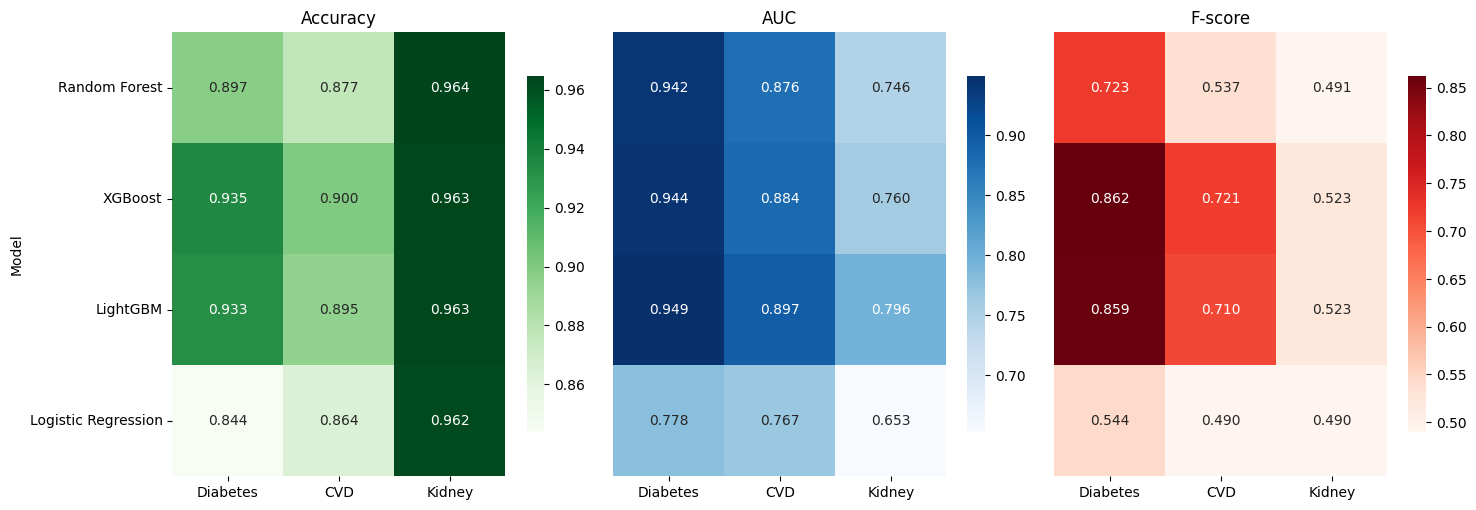

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt


datasets = ["Diabetes", "CVD", "Kidney"]
metrics = ["Accuracy", "AUROC", "F-score"]
results = [results_df_diabetes, results_df_cvd, results_df_kidney]

# Ensure "Model" column exists in each dataframe
for df in results:
    df["Model"] = df.index

# Extract values for each metric
accuracy = pd.concat([df.set_index("Model")["Accuracy"] for df in results], axis=1)
accuracy.columns = datasets

auroc = pd.concat([df.set_index("Model")["AUROC"] for df in results], axis=1)
auroc.columns = datasets

f_score = pd.concat([df.set_index("Model")["F-score"] for df in results], axis=1)
f_score.columns = datasets

# Set up the figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Adjust heatmap settings
heatmap_kwargs = {
    "annot": True,
    "fmt": ".3f",
    "square": True,  # Ensure heatmaps are square
    "cbar_kws": {"shrink": 0.8}  # Shrink colorbars slightly
}

# Plot heatmaps
sns.heatmap(accuracy, **heatmap_kwargs, cmap="Greens", ax=axes[0])
axes[0].set_title("Accuracy")
axes[0].set_ylabel("Model")  # Keep model names only in the first graph

sns.heatmap(auroc, **heatmap_kwargs, cmap="Blues", ax=axes[1], yticklabels=False)
axes[1].set_title("AUC")
axes[1].set_ylabel("")  # Remove y-axis label (model names)

sns.heatmap(f_score, **heatmap_kwargs, cmap="Reds", ax=axes[2], yticklabels=False)
axes[2].set_title("F-score")
axes[2].set_ylabel("")  # Remove y-axis label (model names)

# Adjust layout
plt.tight_layout()
plt.show()
